## Exporting images out of DEA

#### Data in the DataCube is represented as XArray Dataset objects. Xarray follows a data model for representing data which is very similar to the one defined in the NetCDF4 file format. NetCDF4 is a file format designed to store scientific numerical data. Multidimensional arrays can be naturally stored in this format together with dimensions information as well as metadata.

#### XArray has a method called `.to_netcdf()` that can be called to save `Datasets` into disk using the NetCDF file format. Unfortunately, DEA `Datasets` store metadata using a format that is not fully compatible with this function and an alternative function is offered under the DEA library.

#### GeoTIFF is probably the most popular file format for storing georeferenced raster data. DEA also offers a function to save the contents of XArray Datasets in this format.

#### Let's start by loading the Python libraries for this tutorial.

In [28]:
%matplotlib inline

import sys
sys.path.append("./Scripts")
import datacube
import xarray as xr
from dea_plotting import rgb

# This function allows saving DEA Datasets into NetCDF4 file format
from datacube.drivers.netcdf import write_dataset_to_netcdf

# This function allows saving DEA Datasets into GeoTIFF file format
from datacube.helpers import write_geotiff
# New version
#from datacube.utils.cog import write_cog
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


dc = datacube.Datacube(app='exporting_data')

#### We now load some DEA data from Sentinel-2 for Adelaide to experiment with this function.

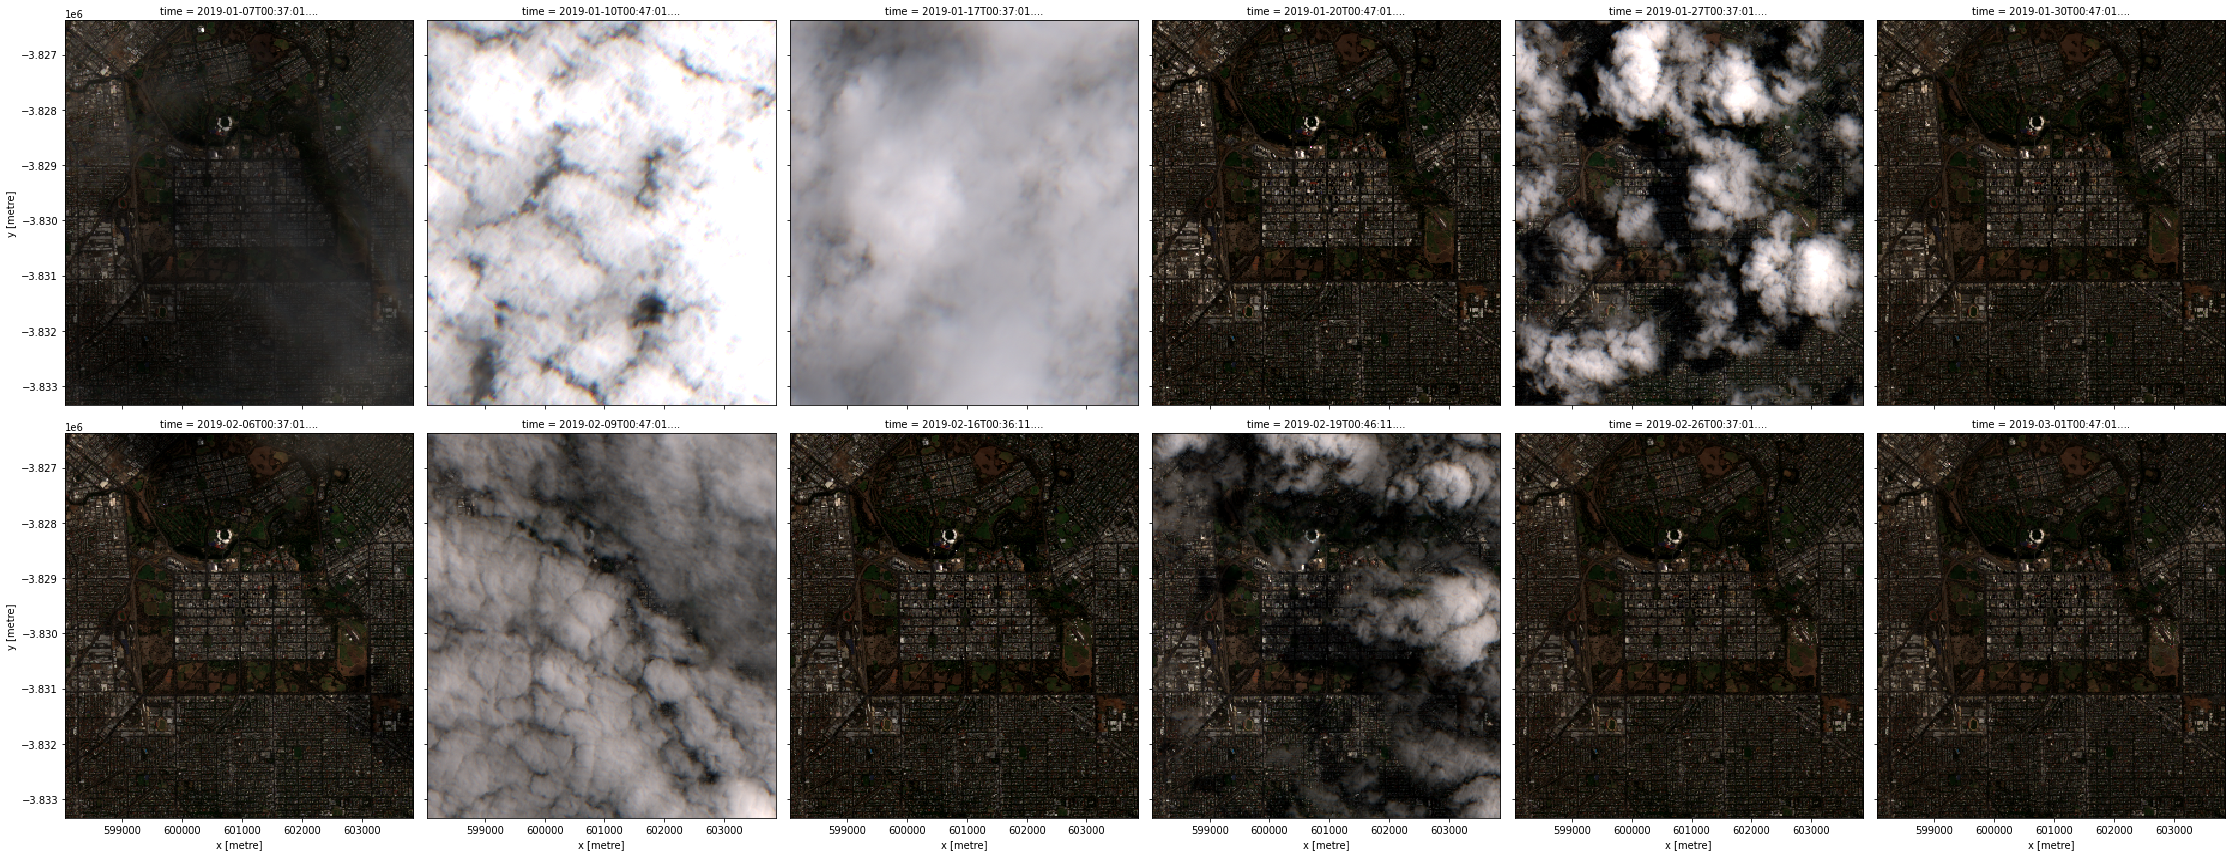

In [2]:
bands = ["nbar_red","nbar_green","nbar_blue"]

query = {'lat': (-34.90, -34.96),
         'lon': (138.57, 138.63),
         'output_crs': 'EPSG:3577',
         'resolution': (-20, 20),
         'measurements': bands,
         'time': ('2019-01-01', '2019-03-01')}

adelaide = dc.load(product='s2a_ard_granule', group_by='solar_day', **query)

rgb(adelaide, col="time", bands=bands, col_wrap=6)

#### To save a copy of this dataset using the NetCDF format, we just need to call the `write_dataset_to_netcdf()` function using the XArray Dataset as the first argument and the name of the file as the second argument.

In [3]:
write_dataset_to_netcdf(adelaide, 'adelaide2019.nc')

#### You will notice a new file has come up on the left panel with name `adelaide.nc`. This file can be downloaded into your computer by right-clicking on it and selecting the `Download` option from the menu.

#### Exercise 6.1: Download the previous file into your local computer. Then, change the name of this file to `adelaide.nc` and using the up arrow icon on the top menu upload (&#8683;) this file again into the DEA Sandbox environment. 

> Note: You should have two netcdf files showing in the file browser with names `adelaide.nc` and `adelaide2019.nc`

#### Now, we are going to load the contents of new file you have uploaded using XArray functionality.

In [4]:
ds = xr.open_dataset('adelaide.nc')

ds

<xarray.Dataset>
Dimensions:      (time: 12, x: 291, y: 348)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-07T00:37:01 ... 2019-03-01T00:...
  * y            (y) float64 -3.826e+06 -3.826e+06 ... -3.833e+06 -3.833e+06
  * x            (x) float64 5.980e+05 5.981e+05 ... 6.038e+05 6.038e+05
    spatial_ref  int32 ...
Data variables:
    nbar_red     (time, y, x) float32 ...
    nbar_green   (time, y, x) float32 ...
    nbar_blue    (time, y, x) float32 ...
Attributes:
    date_created:           2020-09-24T04:34:22.974478
    Conventions:            CF-1.6, ACDD-1.3
    history:                NetCDF-CF file created by datacube version '1.8.3...
    geospatial_bounds:      POLYGON ((138.5660779825314 -34.90013534099648, 1...
    geospatial_bounds_crs:  EPSG:4326
    geospatial_lat_min:     -34.96260349343129
    geospatial_lat_max:     -34.89743543046563
    geospatial_lat_units:   degrees_north
    geospatial_lon_min:     138.56607798253137
    geospatial_lon_max:     138.6338279083858
    geospatial_lon_units:   degrees_east

#### This file can be opened with the generic XArray library or any other program capable of reading NetCDFs and has no dependencies on DEA or Python.

#### NetCDF is not the best file format in terms of compatibility though. GeoTIFF is normally a better option when it comes to sharing our data with others and for working with other geospatial platforms and programs.

#### GeoTiFF offers different configurations for storing multiband data in a single file. Also, NetCDF cannot store multiple times in one file so we need to select single times before we can save the data -- Although this can be hacked by storing time as if they were multiple bands. Let's start by using the previous data to create a file storing a single band.

>Tip: An important caveat to using the `write_geotiff()` function is that it requires an `xarray.Dataset` to be passed to the function. Supplying an `xarray.DataArray` (single variable) will return an error.

In [17]:
ds = xr.open_dataset('adelaide.nc')

write_geotiff('data/red_band.tif', ds[['nbar_red']].isel(time=3))

#### Exercise 6.2: Can you create a new GeoTiFF file storing the blue band for the last temporal entry in the previous Dataset?

In [13]:
write_geotiff('blue_band.tif', ds[['nbar_blue']].isel(time=-1))

#### As we said, GeoTiFFs can store multiple spectral bands in one file. To do this, we can pass the XArray Dataset object without selecting any particular band, but we still need to select one time.

In [14]:
# Write multi-band GeoTIFF
write_geotiff('rgb.tif', ds.isel(time=3))

#### Storing all the times in a Dataset in different GeoTiFFs is also possible looping through the time dimension:

In [15]:
for i in range(len(ds.time)):
    write_geotiff(f'{str(ds.time.values[i])[-30:-19]}.tif', ds.isel(time=i))

#### GeoTiffs and NetCDF are scientific file formats to store the data together with all the metadata to correctly interpret the contents. There are cases when we want to share the output of our DEA analysis with the public using image formats such as PNG or animated GIFFs. 

#### There are many ways of creating PNGs in Python, but one the easiest one is using the `imageio` library to save numpy arrays as images. Let's see how we can do this through an exercise:

#### Exercise 6.3: The following cells describe a few steps that we need to perform to select and transform one image and save it using `imageio`. Follow these steps so the last function can save a PNG with a RGB image of Adelaide.

In [21]:
import imageio
import numpy as np

ds = xr.open_dataset('adelaide.nc')

# 1.- Select the last temporal index from the Dataset object
ds = ds.isel(time=-1)

# 2.- Access the underlying numpy arrays for the red, green and blue bands 
red = ds.nbar_red.values
green = ds.nbar_green.values
blue = ds.nbar_blue.values

# 3.- Stack these three arrays into a 3-dimensional array
rgb = np.dstack((red,green,blue))

rgb.shape, rgb.dtype, rgb.max(), rgb.min()

((348, 291, 3), dtype('float32'), 10000.0, 201.0)

In [22]:


# 5.- Re-scale the values to the [0-1] range
rgb = rgb/rgb.max()

rgb.shape, rgb.dtype, rgb.max(), rgb.min()

((348, 291, 3), dtype('float32'), 1.0, 0.0201)

In [23]:
imageio.imwrite("adelaide.png", rgb)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


#### Animated Giffs are a popular tool to share small videos. This is also very useful to create simple visualisations to represent temporal changes in the Earth surface.

#### Let's see how we can create an animation showing the changes in the water level of 

#### We can use the `load_ard` function to load data from multiple satellites (i.e. Sentinel-2A and -2B), and return a single `xarray.Dataset` containing only observations with a minimum percentage of good quality pixels. This will allow us to create a visually appealing time series animation of observations that are not affected by cloud.

> Note: In the example below, we request only observations which are 95% free of clouds and other poor quality pixels by specifying `min_gooddata=0.95` in the `load_ard()` function.

In [24]:
from dea_datahandling import load_ard

query = {'x': (142.41, 142.57),  
         'y': (-32.225, -32.325),
         'time': ('2018-09-01', '2019-09-01'),
         'measurements': ['nbart_red', 
                          'nbart_green', 
                          'nbart_blue',
                          'nbart_nir_1',
                          'nbart_swir_2'],
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30)}

# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc, 
              products=['s2a_ard_granule', 's2b_ard_granule'], 
              min_gooddata=0.95,
              mask_pixel_quality=False,
              group_by='solar_day',
              **query)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 19 out of 68 time steps with at least 95.0% good quality pixels
Loading 19 time steps


In [27]:
ds

<xarray.Dataset>
Dimensions:       (time: 19, x: 528, y: 414)
Coordinates:
  * x             (x) float64 9.709e+05 9.709e+05 ... 9.867e+05 9.867e+05
  * time          (time) datetime64[ns] 2018-09-11T00:26:59.024000 ... 2019-0...
    spatial_ref   int32 3577
  * y             (y) float64 -3.552e+06 -3.552e+06 ... -3.564e+06 -3.564e+06
Data variables:
    nbart_red     (time, y, x) int16 2366 2236 2293 2160 ... 993 1503 1678 1638
    nbart_green   (time, y, x) int16 1388 1311 1353 1271 ... 786 1099 1218 1217
    nbart_blue    (time, y, x) int16 909 887 892 838 802 ... 557 559 788 894 896
    nbart_nir_1   (time, y, x) int16 3067 2953 3014 2844 ... 2446 2594 2484 2283
    nbart_swir_2  (time, y, x) int16 4867 4827 4815 4636 ... 2315 2851 2860 2687
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

#### Let's plot a selection of observations from the dataset in true colour using the `rgb` function:

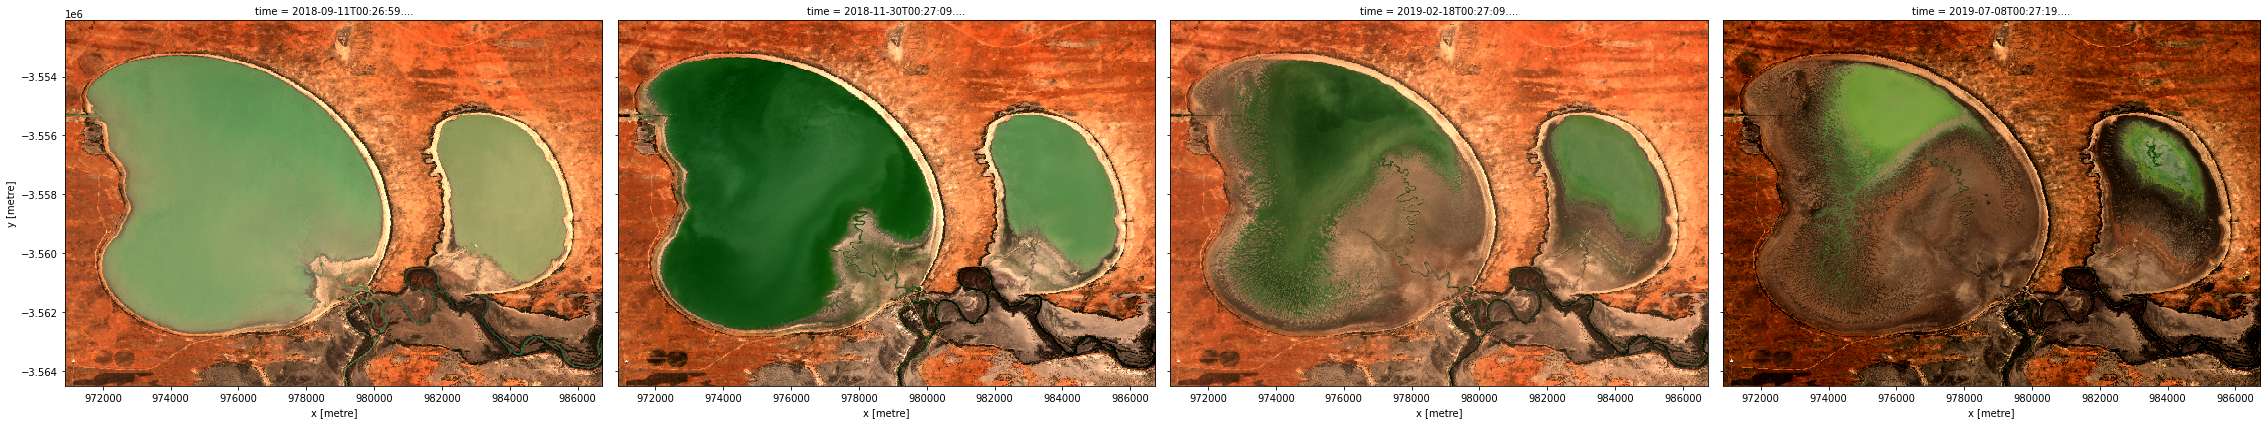

In [29]:
# Plot four images from the dataset
rgb(ds, index=[0, 6, 12, 18])

#### The `xr_animation` function is based on functionality within `matplotlib.animation`. It takes an `xarray.Dataset` and exports a one band or three band (e.g. true or false colour) GIF or MP4 animation showing changes in the landscape across time. 

#### Here, we plot the dataset we loaded above as an animated GIF, using the `['nbart_red', 'nbart_green', 'nbart_blue']` satellite bands to generate a true colour RGB animation. The interval between the animation frames is set to to 100 milliseconds using `interval`, and the width of the animation to 300 pixels using `width_pixels`:

Exporting animation to animated_timeseries.gif


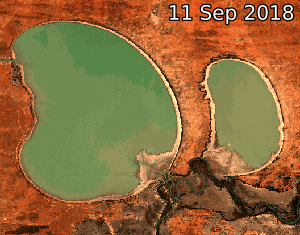

In [31]:
from dea_plotting import xr_animation
from matplotlib import pyplot as plt
from IPython.display import Image

# Produce time series animation of red, green and blue bands
xr_animation(ds=ds, 
             bands=['nbart_red', 'nbart_green', 'nbart_blue'],
             output_path='animated_timeseries.gif',                                
             interval=500, 
             width_pixels=300)

# Plot animated gif
plt.close()
Image(filename='animated_timeseries.gif')

#### Exercise 6.4: Can you create a similar animated Giff for the same area using a false colour composite with these bands: `['nbart_swir_2', 'nbart_nir_1', 'nbart_green']`

#### To finish this tutorial, we are going to see how polygon data can be used in DEA to specify an area of interest. Vector files can be used directly into DEA query objects instead of latitude/longitude thresholds. For example, the following file, stored locally, contains a shapefile defining an area.

In [32]:
poly_path = 'data/reeves_lake_for_demo.shp'

#### `Geopandas` is a Python library for working with geospatial data. It can read a large number of formats and offers convenient functionality to analyse and represent geospatial data.

<Figure size 432x288 with 0 Axes>

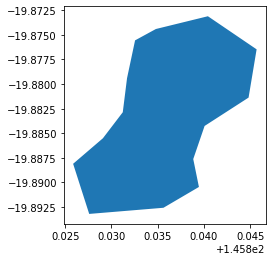

In [33]:
import geopandas as gpd

plt.clf()
shape_plot = gpd.read_file('data/reeves_lake_for_demo.shp')
shape_plot.plot()
plt.show()

Using the `open_polygon_from_shapefile` function from the DEA toolbox, we can extract the geometry information and pass it directly into the DEA query instead of specifying `lat` and `lon` values.

In [34]:
import DEADataHandling
import DEAPlotting

GEOM, SHAPE_NAME = DEADataHandling.open_polygon_from_shapefile(poly_path)

query = {
    'time': ('2016-05-01', '2016-05-30'), 
    'geopolygon': GEOM,
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10)
}

reeves = DEADataHandling.load_clearsentinel2(dc=dc, query=query, sensors=['s2a', 's2b'],
                                             bands_of_interest=['fmask','nbart_green','nbart_nir_1','nbart_swir_2'], 
                                             masked_prop=0, satellite_metadata=True)



Loading s2a pixel quality
    Loading 3 filtered s2a timesteps
Loading s2b pixel quality
    Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


> Note: Load cloud free Sentinel data for all sensors (S2A, S2B) for the above query. Setting 
`satellite_metadata=True` will return the data with a variable that gives the abbreviation
of the satellite that made the observation. Masked_prop allows removing timesteps with missing data greater than masked proportion, useful when animating/communicating results.

#### Let's plot one of the images in the dataset:

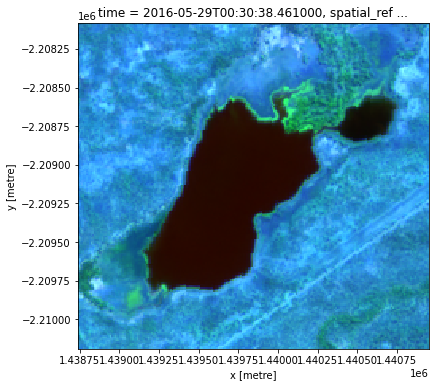

In [35]:
rgb(reeves, bands=['nbart_green','nbart_nir_1','nbart_swir_2'], index=[2])

#### Exercise 6.5: Can you create a true colour Giff animation of this lake?